In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from efficientnet_pytorch import EfficientNet



In [18]:
def load_data(data_dir):
    # Define transforms for training, validation, and test sets
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'validation': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    # Load datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                      for x in ['train', 'validation', 'test']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
                   for x in ['train', 'validation', 'test']}

    return image_datasets, dataloaders


In [19]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=20):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_acc = 0.0
    best_model_wts = model.state_dict()  # Initialize best_model_wts
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    print('Training complete')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [20]:
def test_model(model, dataloaders):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    return cm


In [21]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, cm, class_names):
    # Plot Confusion Matrix
    plt.figure(figsize=(12, 12))
    cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
    cmd.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45, ha='right')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training and validation loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # Plot training and validation accuracy
    epochs = range(1, len(train_accuracies) + 1)
    plt.figure()
    plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()


Epoch 1/20
----------
train Loss: 2.7256 Acc: 0.3321
validation Loss: 1.8791 Acc: 0.7788
Epoch 2/20
----------
train Loss: 1.6402 Acc: 0.7223
validation Loss: 0.7233 Acc: 0.9303
Epoch 3/20
----------
train Loss: 0.8513 Acc: 0.8371
validation Loss: 0.2937 Acc: 0.9939
Epoch 4/20
----------
train Loss: 0.5028 Acc: 0.8987
validation Loss: 0.1706 Acc: 0.9818
Epoch 5/20
----------
train Loss: 0.3605 Acc: 0.9160
validation Loss: 0.0977 Acc: 1.0000
Epoch 6/20
----------
train Loss: 0.2735 Acc: 0.9316
validation Loss: 0.0618 Acc: 1.0000
Epoch 7/20
----------
train Loss: 0.2214 Acc: 0.9431
validation Loss: 0.0534 Acc: 0.9909
Epoch 8/20
----------
train Loss: 0.2017 Acc: 0.9508
validation Loss: 0.0275 Acc: 1.0000
Epoch 9/20
----------
train Loss: 0.1686 Acc: 0.9552
validation Loss: 0.0272 Acc: 1.0000
Epoch 10/20
----------
train Loss: 0.1632 Acc: 0.9547
validation Loss: 0.0172 Acc: 1.0000
Epoch 11/20
----------
train Loss: 0.1405 Acc: 0.9648
validation Loss: 0.0158 Acc: 1.0000
Epoch 12/20
-------

<Figure size 1200x1200 with 0 Axes>

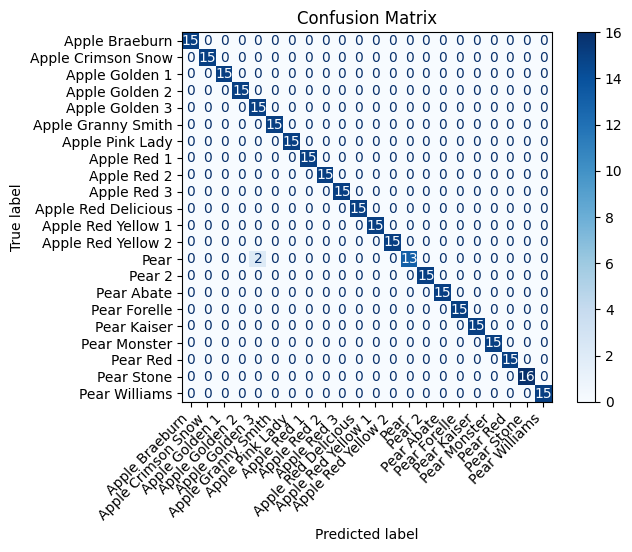

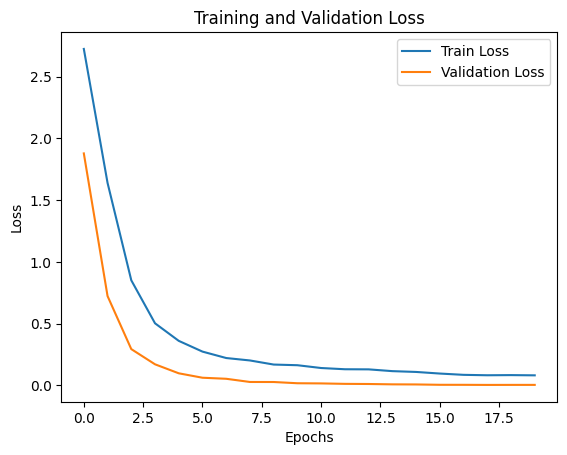

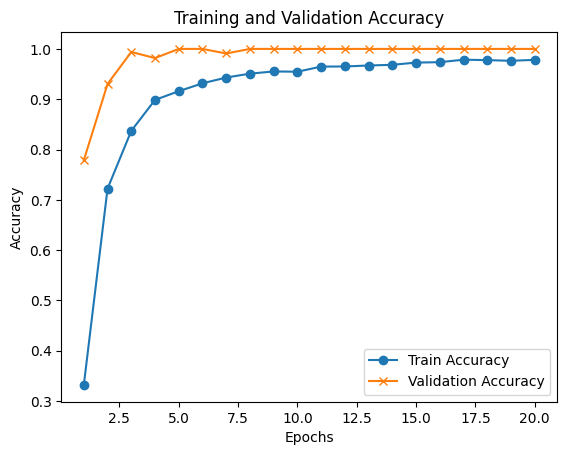

In [24]:
if __name__ == '__main__':
    data_dir = r'C:\Users\Matthew\Documents\collage\Software engineering\data'
    image_datasets, dataloaders = load_data(data_dir)
    
    # Load the EfficientNet model
    num_classes = len(image_datasets['train'].classes)
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    # Modify the final layer of the classifier
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Train the model
    trained_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, criterion, optimizer, dataloaders, num_epochs=20)

    # Test the model
    cm = test_model(trained_model, dataloaders)

    # Plot the results
    class_names = image_datasets['train'].classes
    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, cm, class_names)
